In [1]:
import os
import cPickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import hamming_loss, make_scorer, classification_report
import matplotlib.pyplot as plt
import nltk.data
from nltk.corpus import stopwords

%matplotlib inline
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Windows\ServiceProfile
[nltk_data]     s\LocalService\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# extract from the IMDB data with only 'genres' and 'plot'
imdb_file_name = 'data/plot.pickle'
# full TMDB data
tmdb_file_name = 'data/tmdb_info.pickle'

In [3]:
def load_part(file_name):
    with open(file_name, 'rb') as handle:
        return cPickle.load(handle)

In [4]:
# load the IMDB extract
imdb_dict = load_part(imdb_file_name)

In [5]:
# load TMDB 
tmdb_dict = load_part(tmdb_file_name)

In [6]:
# add 'overview' from TMDB to 'plot' from IMDB (it is a list)
for tmdb_id, imdb_movie in imdb_dict.iteritems():
    if(
        'plot' in imdb_movie and 
        tmdb_id in tmdb_dict and 
        'overview' in tmdb_dict[tmdb_id].__dict__ and
        tmdb_dict[tmdb_id].__dict__['overview'] is not None):
            imdb_movie['plot'].append(tmdb_dict[tmdb_id].__dict__['overview'])

Prepare the labels

In [7]:
# array of list of genres for every movie
labels = np.array([d['genres'] for d in imdb_dict.values() if 'genres' in d and 'plot' in d ])

In [8]:
# create the labels vector
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(labels)
print 'label matrix shape:', y.shape

label matrix shape: (37668L, 28L)


In [9]:
# number of movies for every genre
label_df = pd.DataFrame(mlb.fit_transform(labels))
label_df.columns = mlb.classes_
label_number_df = pd.DataFrame({'cnt' : label_df.sum(axis = 0)})
label_number_df

,cnt
Action,4318
Adult,158
Adventure,2854
Animation,2420
Biography,1404
Comedy,10693
Crime,3766
Documentary,4480
Drama,16567
Family,2738


Limit the number of genres for performance reasons. OneVsRestClassifier fits as many models as labels.

In [10]:
# only leave generes mentioned in 2000 movies or more
cutoff = 2000
major_genres = set(label_number_df[label_number_df['cnt']  > cutoff].index)
major_genres

{u'Action',
 u'Adventure',
 u'Animation',
 u'Comedy',
 u'Crime',
 u'Documentary',
 u'Drama',
 u'Family',
 u'Fantasy',
 u'Horror',
 u'Mystery',
 u'Romance',
 u'Sci-Fi',
 u'Short',
 u'Thriller'}

In [11]:
# find labels only for the major genres
labels = np.array(
    [major_genres.intersection(d['genres']) for d in imdb_dict.values() if 'genres' in d and 'plot' in d ])

In [12]:
# create the labels vector with only major genres
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(labels)
print 'label matrix shape:', y.shape

label matrix shape: (37668L, 15L)


Prepare the features

In [13]:
# the plot consists of a few parts, join them together
features = np.array([ ''.join(d['plot']) for d in imdb_dict.values() if 'genres' in d and 'plot' in d ])

In [14]:
# split into test / train data
F_train, F_test, y_train, y_test = train_test_split(features, y, test_size=0.25, random_state=42)

Convert a collection of text documents to a matrix of token counts

In [15]:
# convert into bag of words
vectorizer = TfidfVectorizer( 
    stop_words = stopwords.words("english"), 
    token_pattern = '[a-zA-Z]+[0-9]*',
    max_df = 0.9, 
    min_df = 0.0001, 
    dtype = np.float32 )
X_train = vectorizer.fit_transform(F_train)
X_test = vectorizer.transform(F_test)

The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

In [16]:
print 'Train label matrix shape:', y_train.shape
print 'Train predictor matrix shape:', X_train.shape
print 'Test label matrix shape:', y_test.shape
print 'Test predictor matrix shape:', X_test.shape

Train label matrix shape: (28251L, 15L)
Train predictor matrix shape: (28251, 31396)
Test label matrix shape: (9417L, 15L)
Test predictor matrix shape: (9417, 31396)


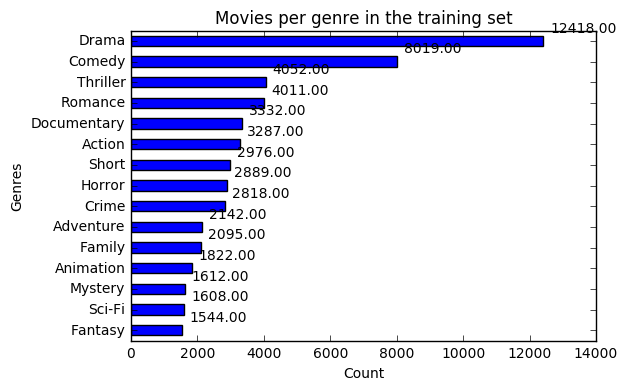

In [17]:
label_df = pd.DataFrame(y_train)
label_df.columns = mlb.classes_
label_number_df = pd.DataFrame({'cnt' : label_df.sum(axis = 0)})
ax = label_number_df.sort_values('cnt')['cnt'].plot(kind="barh", title = 'Movies per genre in the training set')
for p in ax.patches:
    ax.annotate(
        "%.2f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 10), textcoords='offset points')
plt.xlabel('Count')
plt.ylabel('Genres')

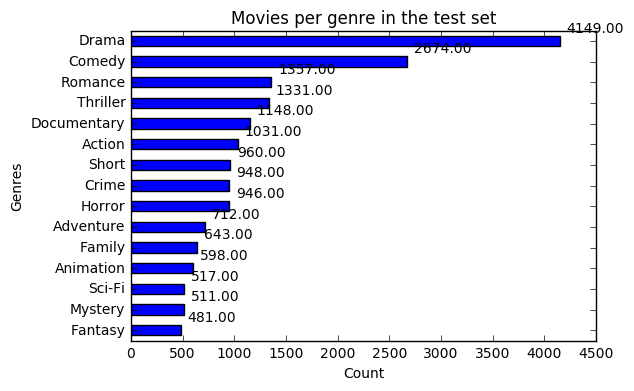

In [18]:
label_df = pd.DataFrame(y_test)
label_df.columns = mlb.classes_
label_number_df = pd.DataFrame({'cnt' : label_df.sum(axis = 0)})
ax = label_number_df.sort_values('cnt')['cnt'].plot(kind="barh", title = 'Movies per genre in the test set')
for p in ax.patches:
    ax.annotate(
        "%.2f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 10), textcoords='offset points')
plt.xlabel('Count')
plt.ylabel('Genres')

The Hamming loss is the fraction of labels that are incorrectly predicted.

In [19]:
param_grid = {
    'estimator__loss': ('hinge', 'log', 'perceptron', 'modified_huber'),
    'estimator__alpha' : np.linspace(1e-04, 1e-06, 100),
    'estimator__penalty' : ('l1', 'l2', 'elasticnet')}

model = OneVsRestClassifier(SGDClassifier(random_state = 761))

model_tunning = GridSearchCV(
    model, 
    param_grid = param_grid, 
    scoring = make_scorer(hamming_loss, greater_is_better = False), 
    n_jobs = -1, 
    verbose = 10)

model_tunning.fit(X_train, y_train)

Fitting 3 folds for each of 1200 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:  6.0min
[Paralle

GridSearchCV(cv=None, error_score='raise',
       estimator=OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=761, shuffle=True,
       verbose=0, warm_start=False),
          n_jobs=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'estimator__alpha': array([  1.00000e-04,   9.90000e-05, ...,   2.00000e-06,   1.00000e-06]), 'estimator__penalty': ('l1', 'l2', 'elasticnet'), 'estimator__loss': ('hinge', 'log', 'perceptron', 'modified_huber')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(hamming_loss, greater_is_better=False),
       verbose=10)

In [20]:
model_tunning.best_params_

{'estimator__alpha': 4.9999999999999996e-05,
 'estimator__loss': 'hinge',
 'estimator__penalty': 'l2'}

Classification quility on the training set

In [21]:
print classification_report(y_train, model_tunning.predict(X_train), target_names = mlb.classes_)

             precision    recall  f1-score   support

     Action       0.95      0.43      0.59      3287
  Adventure       0.98      0.24      0.38      2142
  Animation       0.98      0.50      0.66      1822
     Comedy       0.91      0.66      0.77      8019
      Crime       0.91      0.43      0.58      2818
Documentary       0.96      0.80      0.87      3332
      Drama       0.84      0.82      0.83     12418
     Family       0.97      0.37      0.54      2095
    Fantasy       0.97      0.22      0.36      1544
     Horror       0.94      0.65      0.77      2889
    Mystery       0.99      0.14      0.25      1612
    Romance       0.92      0.36      0.51      4011
     Sci-Fi       0.95      0.54      0.68      1608
      Short       0.98      0.42      0.59      2976
   Thriller       0.91      0.37      0.52      4052

avg / total       0.92      0.56      0.66     54625



Classification quility on the test set

In [22]:
print classification_report(y_test, model_tunning.predict(X_test), target_names = mlb.classes_)

             precision    recall  f1-score   support

     Action       0.76      0.26      0.39      1031
  Adventure       0.74      0.09      0.17       712
  Animation       0.90      0.30      0.45       598
     Comedy       0.74      0.48      0.58      2674
      Crime       0.70      0.23      0.35       948
Documentary       0.88      0.64      0.74      1148
      Drama       0.72      0.69      0.71      4149
     Family       0.83      0.22      0.35       643
    Fantasy       0.88      0.10      0.18       481
     Horror       0.85      0.48      0.61       946
    Mystery       0.71      0.04      0.08       511
    Romance       0.66      0.18      0.29      1357
     Sci-Fi       0.82      0.34      0.48       517
      Short       0.91      0.25      0.39       960
   Thriller       0.61      0.16      0.26      1331

avg / total       0.75      0.40      0.49     18006



In [24]:
model_dict = {}
model_dict['model'] = model_tunning
model_dict['X_train'] = X_train
model_dict['y_train'] = y_train
model_dict['X_test'] = X_test
model_dict['y_test'] = y_test
model_dict['labels_names'] = mlb.classes_

with open('models/sgd_text_model.pickle', 'wb') as handle:
    cPickle.dump(model_dict, handle, protocol = cPickle.HIGHEST_PROTOCOL)

In [27]:
d = load_part('models/sgd_text_model.pickle')

In [29]:
print classification_report(d['y_test'], d['model'].predict(d['X_test']), target_names = d['labels_names'])

             precision    recall  f1-score   support

     Action       0.76      0.26      0.39      1031
  Adventure       0.74      0.09      0.17       712
  Animation       0.90      0.30      0.45       598
     Comedy       0.74      0.48      0.58      2674
      Crime       0.70      0.23      0.35       948
Documentary       0.88      0.64      0.74      1148
      Drama       0.72      0.69      0.71      4149
     Family       0.83      0.22      0.35       643
    Fantasy       0.88      0.10      0.18       481
     Horror       0.85      0.48      0.61       946
    Mystery       0.71      0.04      0.08       511
    Romance       0.66      0.18      0.29      1357
     Sci-Fi       0.82      0.34      0.48       517
      Short       0.91      0.25      0.39       960
   Thriller       0.61      0.16      0.26      1331

avg / total       0.75      0.40      0.49     18006

